In [1]:
import numpy as np
from sympy import var,Function,Symbol,Rational
from ComputabilityGraphs.CMTVS import CMTVS
from bgc_md2.helper import bgc_md2_computers
from bgc_md2.resolve.mvars import (
    InFluxesBySymbol,
    OutFluxesBySymbol,
    InternalFluxesBySymbol,
    TimeSymbol,
    StateVariableTuple,
)
from matplotlib import pyplot as plt

In [2]:
# obtain dictionary of symbols for equations from txt file
params_in = open(r"mini_model_sym_dict.txt", 'r')
sym_dict = {}
for line in params_in:
    k, v = line.strip().split('=')
    sym_dict[k.strip()] = v.strip()
    
params_in.close()

In [3]:
#define all the symbols you are going to use in the equations

for k in sym_dict.keys():
    code=k+" = Symbol('{0}')".format(k)
    exec(code)
    
func_dict = {
    "Gpp_grass": "Total C production for grass in g/m^2*month FIXME"
}
for k in func_dict.keys():
    code=k+" = Function('{0}')".format(k)
    exec(code)    
    
#I_wood=Function("I_wood") 
t=TimeSymbol("t") # the symbol used for time since it has a special role
e = Symbol("e")   # for exponential functions

cprodc_B = 1 - cprodc_A
k_STRUCC_1 = dec1_1 * defac_0 * (e**(-3*strlig_1))   # total C flow from surf strucc layer

# formulate the model
mvs = CMTVS(
    {
        StateVariableTuple( # the pool names in your preferred order
            (
                AGLIVC,
                BGLIVC,
                STDEDC,
                STRUCC_1,
                STRUCC_2,
                SOM1C_1,
                SOM1C_2,
                SOM2C,
                SOM3C,
                METABC_1,
                METABC_2,
                CROOTC,
                FBRCHC,
                FROOTC,
                RLEAVC,
                RLWODC,
                WOOD1C,
                WOOD2C,
                WOOD3C,
            )
        ), 
        t, 
        InFluxesBySymbol({
            AGLIVC: Gpp_grass(t)*cprodc_A, 
            BGLIVC: Gpp_grass(t)*cprodc_B
        }),
        OutFluxesBySymbol({    # CO2 losses
            STDEDC: fallrt * STDEDC,
            STRUCC_1: ((k_STRUCC_1 * Rational(3,10) * strlig_1) + (Rational(45,100)* k_STRUCC_1 * (1 - strlig_1))) * STRUCC_1,
            STRUCC_2: (dec1_2 * defac_0 * (e**(-3*strlig_2))) * STRUCC_2  # anerb=1 see litdec.F
        }),
        InternalFluxesBySymbol({
            (STRUCC_1, SOM1C_1): Rational(55,100) * (k_STRUCC_1 * (1 - strlig_1)) * STRUCC_1,
            (STRUCC_1, SOM2C): (dec1_1 * defac_0 * (e**(-3*strlig_1))) * (Rational(7,10) * strlig_1) * STRUCC_1  
        }),
    },
    bgc_md2_computers()

)

In [4]:
#start to query the model description..
M=mvs.get_CompartmentalMatrix()
#M.inverse_LU()

In [5]:
mvs.get_InputTuple()

Matrix([
[      cprodc_A*Gpp_grass(t)],
[(1 - cprodc_A)*Gpp_grass(t)],
[                          0],
[                          0],
[                          0],
[                          0],
[                          0],
[                          0],
[                          0],
[                          0],
[                          0],
[                          0],
[                          0],
[                          0],
[                          0],
[                          0],
[                          0],
[                          0],
[                          0]])

In [6]:
mvs.get_StateVariableTuple()

Matrix([
[  AGLIVC],
[  BGLIVC],
[  STDEDC],
[STRUCC_1],
[STRUCC_2],
[ SOM1C_1],
[ SOM1C_2],
[   SOM2C],
[   SOM3C],
[METABC_1],
[METABC_2],
[  CROOTC],
[  FBRCHC],
[  FROOTC],
[  RLEAVC],
[  RLWODC],
[  WOOD1C],
[  WOOD2C],
[  WOOD3C]])

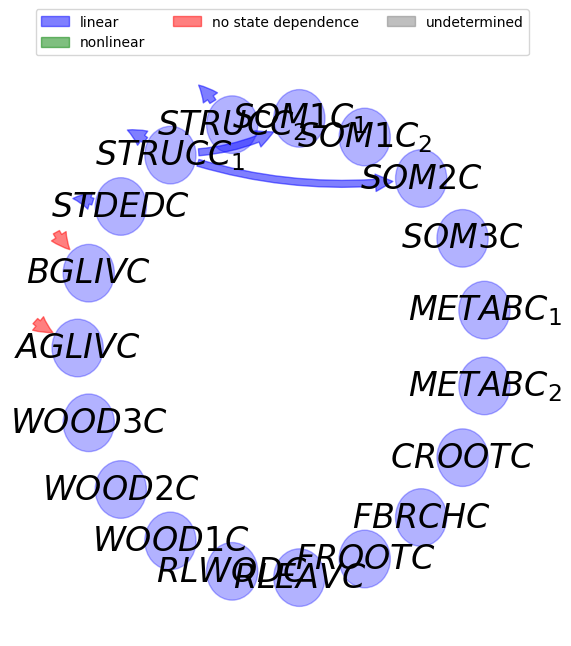

In [7]:
from bgc_md2.helper import compartmental_graph
compartmental_graph(mvs)

In [8]:
from bgc_md2.display_helpers import mass_balance_equation
mass_balance_equation(mvs)

<IPython.core.display.Math object>

In [9]:
mvs.computable_mvar_types()

frozenset({CompartmentalSystems.smooth_reservoir_model.SmoothReservoirModel,
           bgc_md2.resolve.mvars.CompartmentalMatrix,
           bgc_md2.resolve.mvars.InFluxesBySymbol,
           bgc_md2.resolve.mvars.InputTuple,
           bgc_md2.resolve.mvars.InternalFluxesBySymbol,
           bgc_md2.resolve.mvars.OutFluxesBySymbol,
           bgc_md2.resolve.mvars.OutputTuple,
           bgc_md2.resolve.mvars.StateVariableTuple,
           bgc_md2.resolve.mvars.TimeSymbol})

In [10]:
#for comparison the century model as found in our database
#from bgc_md2.models.Parton1987SoilSciSocAmJ.source_by_name import mvs as mvs_century
#mvs_century.get_InputTuple()
#compartmental_graph(mvs_century)
#mass_balance_equation(mvs_century)
#BI=mvs_century.get_BibInfo()
#BI.sym_dict

In [11]:
# I will just create a dictionary with completely arbitrary values for the parameters
# and one for the functions 
# Don't get a heart attack .. how ignorant I might be about the TRUE values... 
# This is just a guide for the technical side

# first I find out which parameters there are...
# Any sympy expression has a free_symbols method and I implemented a similar one
# for the symbolic model class. Its a shortcut that looks at matrix and Inputs 
# and removes the statevariables automatically
srm=mvs.get_SmoothReservoirModel()
srm.free_symbols
# Of course you would probably know this but this little test is useful half way through 
# to check which parameters are still in need of a value...

{STDEDC,
 STRUCC_1,
 STRUCC_2,
 cprodc_A,
 dec1_1,
 dec1_2,
 defac_0,
 e,
 fallrt,
 strlig_1,
 strlig_2,
 t}

In [12]:
# t is the symbol for time and not a parameter...fake values for the others
par_dict={
    STDEDC: 1,
    STRUCC_1: 1,
    STRUCC_2: 1,
    cprodc_A: 1,
    dec1_1: 1,
    dec1_2: 1,
    defac_0: 1,
    e: 1,
    fallrt: 1,
    strlig_1: 1,
    strlig_2: 1,
}

In [13]:
# The functions are a bit more obvious since we only expressed a view of them explicitly 
# but we could also find them as the little example schows...
test_f = Function("test_f")
x = Symbol("x")
expr = x**2*test_f(x)
expr, expr.atoms(Function)

(x**2*test_f(x), {test_f(x)})

In [14]:
# Now for our real model, where functions could be in the  
mvs.get_InputTuple().atoms(Function).union(mvs.get_CompartmentalMatrix().atoms(Function))

{Gpp_grass(t)}

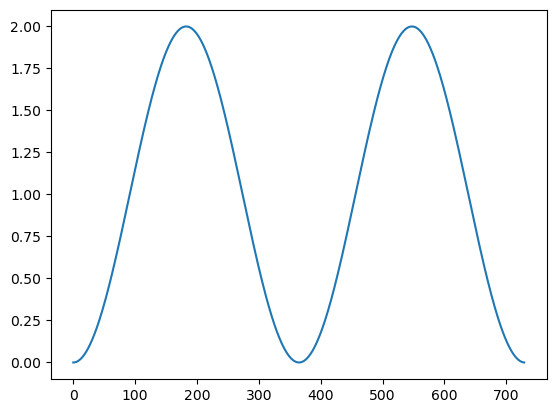

In [15]:
# we build a concrete numeric version of this symbolic function,
# which will in real live in all likelyhood be an interpolation from data (probably from a netcdf file)
# We can build such a function later when you tell me about your data format.
# Here invented  a seasonal function with a peak in the middle of the year
def num_G_pp_grass(t):
    omega=2*np.pi/365 #period of 365 days  
    phi=np.pi # phaseshift to start at the lowest value at t=0
    return 1+np.cos(omega*t + phi)
ts=np.array(range(730))
ax=plt.plot(ts,num_G_pp_grass(ts))
func_dict={Gpp_grass(t): num_G_pp_grass}

In [39]:
# The last thing we need to run the model are the startvalues
svd={
    AGLIVC:0.1, 
    BGLIVC:0.1, 
    STDEDC:1.1, 
    STRUCC_1:0.1, 
    STRUCC_2:0.1, 
    SOM1C_1:0.1,
    SOM1C_2:0.1,
    SOM2C:0.1,
    SOM3C:0.1,
    METABC_1:0.1,
    METABC_2:0.1,
    CROOTC:0.1,
    FBRCHC:0.1,
    FROOTC:0.1,
    RLEAVC:0.1,
    RLWODC:0.1,
    WOOD1C:0.1,
    WOOD2C:0.1,
    WOOD3C:0.1
}
svt=mvs.get_StateVariableTuple()
svt

Matrix([
[  AGLIVC],
[  BGLIVC],
[  STDEDC],
[STRUCC_1],
[STRUCC_2],
[ SOM1C_1],
[ SOM1C_2],
[   SOM2C],
[   SOM3C],
[METABC_1],
[METABC_2],
[  CROOTC],
[  FBRCHC],
[  FROOTC],
[  RLEAVC],
[  RLWODC],
[  WOOD1C],
[  WOOD2C],
[  WOOD3C]])

In [40]:
# We make a small test that we have all startvalues of them by substituting the values  for the symbols
svt.subs(svd)


Matrix([
[0.1],
[0.1],
[1.1],
[0.1],
[0.1],
[0.1],
[0.1],
[0.1],
[0.1],
[0.1],
[0.1],
[0.1],
[0.1],
[0.1],
[0.1],
[0.1],
[0.1],
[0.1],
[0.1]])

In [41]:
# Now we can update our mvs object (CMTVS Connected Multi Type Variable Set) 
from bgc_md2.resolve.mvars import NumericParameterization,NumericStartValueDict,NumericSimulationTimes
mvs=mvs.update(
    [
        NumericParameterization(par_dict=par_dict,func_dict=func_dict),
        NumericStartValueDict(svd),
        NumericSimulationTimes(ts)
    ]
)

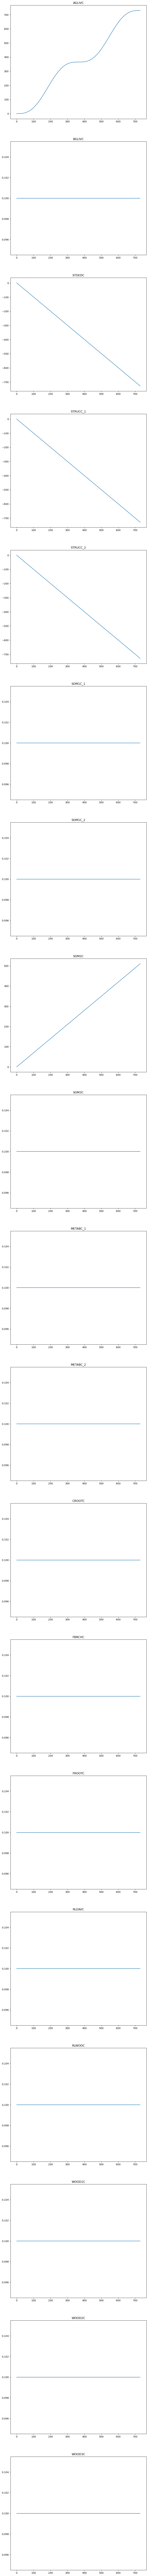

In [42]:
sa=mvs.get_NumericSolutionArray()
_, n_pools=sa.shape
fig = plt.figure(figsize=(10,10*n_pools))
axs=fig.subplots(n_pools)
for i in range(n_pools):
    ax=axs[i]
    ax.plot(ts,sa[:,i])
    ax.set_title(svt[i])

array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >], dtype=object)

Text(0.5, 1.0, 'WOOD3C')